#Imports

In [25]:
!pip install pyspark

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, desc, udf
from pyspark.sql.types import DoubleType
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline

#dl
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier



# Initialisation de la session Spark

In [27]:
spark = SparkSession.builder \
    .appName("Olympics Prediction") \
    .getOrCreate()

# Initialisation des données

In [28]:
athletes_df = spark.read.json("olympic_athletes.json")
athletes_df.show(5)

+--------------------+--------------+--------------------+------------------+----+----------------+--------------------+
|   athlete_full_name|athlete_medals|         athlete_url|athlete_year_birth| bio|      first_game|games_participations|
+--------------------+--------------+--------------------+------------------+----+----------------+--------------------+
|Cooper WOODS-TOPA...|          NULL|https://olympics....|            2000.0|NULL|    Beijing 2022|                   1|
|      Felix ELOFSSON|          NULL|https://olympics....|            1995.0|NULL|PyeongChang 2018|                   2|
|       Dylan WALCZYK|          NULL|https://olympics....|            1993.0|NULL|    Beijing 2022|                   1|
|       Olli PENTTALA|          NULL|https://olympics....|            1995.0|NULL|    Beijing 2022|                   1|
|    Dmitriy REIKHERD|          NULL|https://olympics....|            1989.0|NULL|    Beijing 2022|                   1|
+--------------------+----------

# Pré-traitement des données

In [29]:
# Supprimer les athlètes nés avant 1985
athletes_df = athletes_df.filter(col("athlete_year_birth") >= 1985)

# Ajouter une colonne "medal" (1 si l'athlète a gagné une médaille, 0 sinon)
athletes_df = athletes_df.withColumn("medal", when(col("athlete_medals").isNotNull(), 1).otherwise(0))

# Remplacer les valeurs nulles dans les colonnes numériques par la moyenne de la colonne
numerical_columns = ["games_participations", "athlete_year_birth"]
for column in numerical_columns:
    mean_value = athletes_df.selectExpr(f"avg({column}) as mean").first()["mean"]
    athletes_df = athletes_df.na.fill({column: mean_value})

# Remplacer les valeurs nulles dans les colonnes de type string par "Unknown"
string_columns = ["first_game"]
athletes_df = athletes_df.na.fill({col: "Unknown" for col in string_columns})

# Vérifier les modifications
athletes_df.show(5)


+--------------------+--------------+--------------------+------------------+----+----------------+--------------------+-----+
|   athlete_full_name|athlete_medals|         athlete_url|athlete_year_birth| bio|      first_game|games_participations|medal|
+--------------------+--------------+--------------------+------------------+----+----------------+--------------------+-----+
|Cooper WOODS-TOPA...|          NULL|https://olympics....|            2000.0|NULL|    Beijing 2022|                   1|    0|
|      Felix ELOFSSON|          NULL|https://olympics....|            1995.0|NULL|PyeongChang 2018|                   2|    0|
|       Dylan WALCZYK|          NULL|https://olympics....|            1993.0|NULL|    Beijing 2022|                   1|    0|
|       Olli PENTTALA|          NULL|https://olympics....|            1995.0|NULL|    Beijing 2022|                   1|    0|
|    Dmitriy REIKHERD|          NULL|https://olympics....|            1989.0|NULL|    Beijing 2022|            

# Visualisation des données

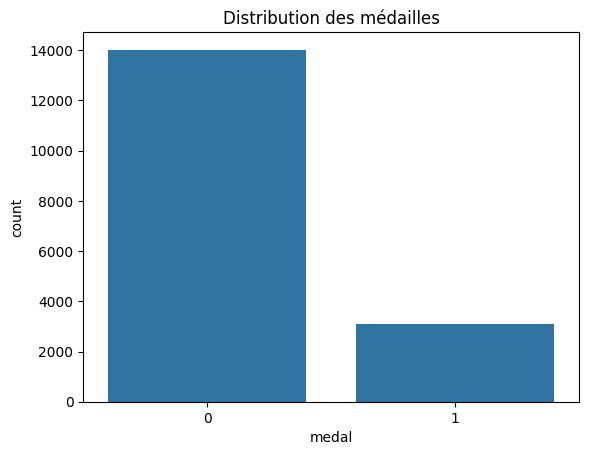

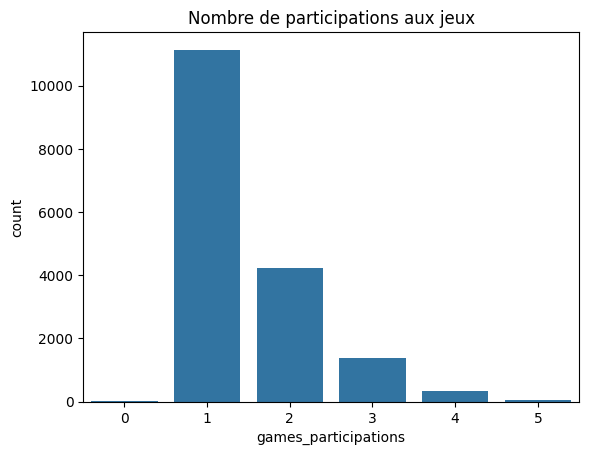

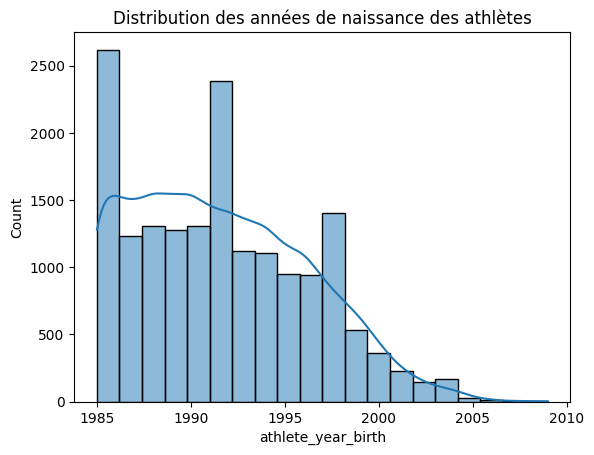

In [30]:
# Convertir en Pandas DataFrame pour l'affichage
athletes_pd = athletes_df.toPandas()

# Distribution des médailles
sns.countplot(x='medal', data=athletes_pd)
plt.title('Distribution des médailles')
plt.show()

# Nombre de participations aux jeux
sns.countplot(x='games_participations', data=athletes_pd)
plt.title('Nombre de participations aux jeux')
plt.show()

# Distribution des années de naissance des athlètes
sns.histplot(athletes_pd['athlete_year_birth'], bins=20, kde=True)
plt.title('Distribution des années de naissance des athlètes')
plt.show()


# Préparation des données à l'entrainement

In [31]:
# Indexer la colonne "first_game" pour One-Hot Encoding
indexer = StringIndexer(inputCol="first_game", outputCol="first_game_index")
athletes_df = indexer.fit(athletes_df).transform(athletes_df)

# Encodage One-Hot
encoder = OneHotEncoder(inputCol="first_game_index", outputCol="first_game_encoded")
athletes_df = encoder.fit(athletes_df).transform(athletes_df)

# Assembler les caractéristiques dans un vecteur
assembler = VectorAssembler(inputCols=["games_participations", "athlete_year_birth", "first_game_encoded"], outputCol="features")
athletes_df = assembler.transform(athletes_df)

# Diviser les données en ensembles d'entraînement et de test
(train_data, test_data) = athletes_df.randomSplit([0.8, 0.2], seed=42)


# Modèles de Deep Learning

## 1) MLP

In [32]:
# Définir les couches du modèle MLP
layers = [len(train_data.select("features").first()[0]), 5, 4, 2]

# Initialiser le classificateur MLP
mlp = MultilayerPerceptronClassifier(layers=layers, featuresCol='features', labelCol='medal', maxIter=100)

# Entraîner le modèle
model_mlp = mlp.fit(train_data)

# Évaluer le modèle
result_mlp = model_mlp.transform(test_data)
predictionAndLabels_mlp = result_mlp.select("prediction", "medal")
accuracy_mlp = predictionAndLabels_mlp.filter(predictionAndLabels_mlp['prediction'] == predictionAndLabels_mlp['medal']).count() / float(test_data.count())
print(f'MLP Accuracy: {accuracy_mlp}')


MLP Accuracy: 0.8208866408806903


## 2) Régression logistique

In [33]:
# Initialiser le classificateur de régression logistique
lr = LogisticRegression(featuresCol='features', labelCol='medal', maxIter=100)

# Entraîner le modèle
model_lr = lr.fit(train_data)

# Évaluer le modèle
result_lr = model_lr.transform(test_data)
predictionAndLabels_lr = result_lr.select("prediction", "medal")
accuracy_lr = predictionAndLabels_lr.filter(predictionAndLabels_lr['prediction'] == predictionAndLabels_lr['medal']).count() / float(test_data.count())
print(f'Logistic Regression Accuracy: {accuracy_lr}')


Logistic Regression Accuracy: 0.8241594763463255


# 3) Décision Tree

In [34]:
# Initialiser le random tree
rf = RandomForestClassifier(featuresCol='features', labelCol='medal', numTrees=100)

# Entraîner le modèle
model_rf = rf.fit(train_data)

# Évaluer le modèle
result_rf = model_rf.transform(test_data)
predictionAndLabels_rf = result_rf.select("prediction", "medal")
accuracy_rf = predictionAndLabels_rf.filter(predictionAndLabels_rf['prediction'] == predictionAndLabels_rf['medal']).count() / float(test_data.count())
print(f'Random Forest Accuracy: {accuracy_rf}')


Random Forest Accuracy: 0.8208866408806903


# Evaluation des modèles

In [35]:
model_names = ['MLP', 'Logistic Regression', 'Random Forest']
accuracies = [accuracy_mlp, accuracy_lr, accuracy_rf]

for name, acc in zip(model_names, accuracies):
    print(f'{name} Accuracy: {acc}')


MLP Accuracy: 0.8208866408806903
Logistic Regression Accuracy: 0.8241594763463255
Random Forest Accuracy: 0.8208866408806903


# Visualisation des résultats

In [37]:
# Définir une fonction UDF pour extraire la probabilité de la classe positive
def extract_probability(probability):
    return float(probability[1])

# Enregistrer la fonction UDF
extract_prob_udf = udf(extract_probability, DoubleType())

# Modèle MLP
result_mlp = result_mlp.withColumn("probability_positive", extract_prob_udf(col("probability")))
top_athletes_mlp = result_mlp.sort(desc("probability_positive"))

# Modèle de Régression Logistique
result_lr = result_lr.withColumn("probability_positive", extract_prob_udf(col("probability")))
top_athletes_lr = result_lr.sort(desc("probability_positive"))

# Modèle de Forêt Aléatoire
result_rf = result_rf.withColumn("probability_positive", extract_prob_udf(col("probability")))
top_athletes_rf = result_rf.sort(desc("probability_positive"))

# Afficher les 10 athlètes les plus susceptibles de gagner des médailles pour chaque modèle
print("Athlètes susceptible de gagner une médaille pour le  MLP modèle:")
top_athletes_mlp.select("athlete_full_name", "probability_positive").show(10, truncate=False)

print("Athlètes susceptible de gagner une médaille pour la régréssion logistique:")
top_athletes_lr.select("athlete_full_name", "probability_positive").show(10, truncate=False)

print("Athlètes susceptible de gagner une médaille pour le Random Forest")
top_athletes_rf.select("athlete_full_name", "probability_positive").show(10, truncate=False)


Athlètes susceptible de gagner une médaille pour le  MLP modèle:
+-------------------+--------------------+
|athlete_full_name  |probability_positive|
+-------------------+--------------------+
|Bombette MARTIN    |0.18165596957260158 |
|Katie GRIMES       |0.18165596957260158 |
|Anna DULCE         |0.18165596957260147 |
|Yiting YU          |0.18165596957260147 |
|Oleksii SEREDA     |0.18165596957260147 |
|Wenhui ZENG        |0.18165596957260147 |
|Keet OLDENBEUVING  |0.1816559695726013  |
|Kohl TAMARUA-HORTON|0.1816559695726013  |
|Okyanus ARIKAN     |0.1816559695726013  |
|Lauren LEE         |0.1816559695726013  |
+-------------------+--------------------+
only showing top 10 rows

Athlètes susceptible de gagner une médaille pour la régréssion logistique:
+---------------------+--------------------+
|athlete_full_name    |probability_positive|
+---------------------+--------------------+
|Alia ATKINSON        |0.8274079386141401  |
|Federica PELLEGRINI  |0.8274079386141401  |
|Jeanet